In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 1.X

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.X`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [3]:
#Installing BERT module
!pip install bert-tensorflow==1.0.1

     |████████████████████████████████| 71kB 3.6MB/s 


In [4]:
!mkdir data
!mkdir model

## Import libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
import os

print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

tensorflow version :  1.15.2
tensorflow_hub version :  0.10.0



## Load the data

In [ ]:
DATA_COLUMN = 'Description'
LABEL_COLUMN = 'Class'
# The list containing all the classes
label_list = [0, 1, 2]

   ID  Class                                        Description
0   0      0  從小就不喜歡牽手的寶貝每次只要一偷牽妳的手妳就會作勢要咬我但每次都是輕輕含住不會弄痛我昨天終...
1   1      0  外公因為肺癌越發嚴重的關係長期住在醫院從發病到治療大概經歷了兩年多其中時好時壞好的時候能在醫...
2   2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
3   3      0  有時候叫uber結果給我來熊貓真的很嚇人熊貓外送員真的都很89很奇葩只有熊貓會一直89式的裝...
4   4      1  好幾次有輕生的想法但不希望自己離開的方式浪費社會資源憂鬱症好幾年了 嚴重到無法形容自己的狀態...
(1000, 3)
**************************************************
各風險則數: 
高風險: 0 則
中風險: 27 則
低風險: 973 則
總共: 1000 則


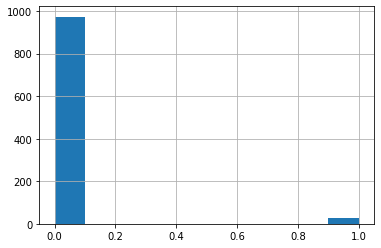

In [39]:
# Set the output directory for saving model file
OUTPUT_DIR = 'model'

data_source = "data/Dcard_1000_1091231.csv"

data_df = pd.read_csv(data_source, encoding='utf8', delimiter=',')
print(data_df.head())
print(data_df.shape)

print("*"*50)
print("各風險則數: ")
data_df['Class'].hist()

print(f"高風險: {data_df[data_df['Class'] == 2].shape[0]} 則") 
print(f"中風險: {data_df[data_df['Class'] == 1].shape[0]} 則") 
print(f"低風險: {data_df[data_df['Class'] == 0].shape[0]} 則")
print(f"總共: {data_df.shape[0]} 則")

## Delete stop words

In [40]:
stop_words = []
new_description_list = []

with open('./data/stop_words.txt', 'r', encoding='utf8') as f:
  for w in f.readlines():
    w = w.replace('\n', '')
    stop_words.append(w)

for index, row in data_df.iterrows():
  new_description = row['Description']
  for w in stop_words:
    new_description = new_description.replace(w,'')
  new_description_list.append(new_description)

data_df['Description'] = new_description_list

print(data_df.head())

   ID  Class                                        Description
0   0      0  從小就不喜歡牽手的寶貝每次只要一偷牽妳的手妳就會作勢要咬我但每次都是輕輕含住不會弄痛我昨天終...
1   1      0  外公因為肺癌越發嚴重的關係長期住在醫院從發病到治療大概經歷了兩年多其中時好時壞好的時候能在醫...
2   2      0  最近心情真的很糟 可能習慣了但也覺得少了一點什麼 面對親人的生離死別 真的是最痛苦的事 治療...
3   3      0  有時候叫uber結果給我來熊貓真的很嚇人熊貓外送員真的都很很奇葩只有熊貓會一直式的裝客氣假裝...
4   4      1  好幾次有輕生的想法但不希望自己離開的方式浪費社會資源憂鬱症好幾年了 嚴重到無法形容自己的狀態...


In [43]:
train, val =  train_test_split(data_df, test_size = 0.1, random_state = 101) #101 200 113 200

#Training set sample
print(train.head())

print("#"*100)
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)

print("#"*100)
print("high risk train: ",train[train['Class'] == 2].shape[0])
print("medium risk train: ",train[train['Class'] == 1].shape[0])
print("low risk train: ",train[train['Class'] == 0].shape[0])

print("high risk val: ",val[val['Class'] == 2].shape[0])
print("medium risk val: ",val[val['Class'] == 1].shape[0])
print("low risk val: ",val[val['Class'] == 0].shape[0])

      ID  Class                                        Description
992  992      0  因為最近基隆陰雨綿綿衣服不容易乾所以即便昨天身體很不舒服還是出門去洗衣店把衣服洗一洗烘乾剛好...
31    31      0  好難過 想到未來的每一步 她都沒有參與了 她離開我了她不愛我了   深夜 醒來 心好痛 那種...
247  247      0  最近偶爾覺得自己好像好了走路不會在害怕的左顧右盼不會不知道眼神應該放在那個位置才是對的不會上...
806  806      0  收到一封外送簡訊寫著正為你送貨中看到這裡我很驚訝因為我沒有叫外送ㄚ心想著會不會是詐騙集團所以...
189  189      0  相信很多人名字都有特殊字最近報考研究所哇你每一家都要我造字造字傳真都要花元列印費元傳真費費用...
####################################################################################################
Training Set Shape : (900, 3)
Validation Set Shape : (100, 3)
####################################################################################################
high risk train:  0
medium risk train:  24
low risk train:  876
high risk val:  0
medium risk val:  3
low risk val:  97


## Upsample high risk data (only for training dataset)

(24, 3)
(1740, 3)
####################################################################################################
high risk train:  0
medium risk train:  864
low risk train:  876
high risk val:  0
medium risk val:  3
low risk val:  97
**************************************************
各風險則數: 


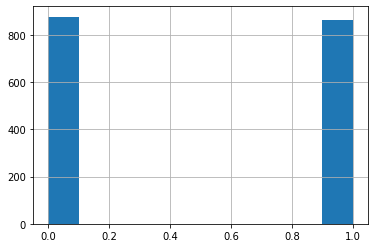

In [44]:
train_1 = train[train['Class']==1]
print(train_1.shape)

for i in range(int(876/24)-1): # large train / small train
  train = pd.concat([train, train_1])

print(train.shape)

print("#"*100)
print("high risk train: ",train[train['Class'] == 2].shape[0])
print("medium risk train: ",train[train['Class'] == 1].shape[0])
print("low risk train: ",train[train['Class'] == 0].shape[0])

print("high risk val: ",val[val['Class'] == 2].shape[0])
print("medium risk val: ",val[val['Class'] == 1].shape[0])
print("low risk val: ",val[val['Class'] == 0].shape[0])

print("*"*50)
print("各風險則數: ")
train['Class'].hist()

## Data preprocessing

BERT model accept only a specific type of input and the datasets are usually structured to have have the following four features:

guid : A unique id that represents an observation.  
text_a : The text we need to classify into given categories  
text_b: It is used when we're training a model to understand the relationship between sentences and it does not apply for classification problems.  
label: It consists of the labels or classes or categories that a given text belongs to.  
In our dataset we have text_a and label. The following code block will create objects for each of the above mentioned features for all the records in our dataset using the InputExample class provided in the BERT library.

In [46]:
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [47]:
train_InputExamples

992    <bert.run_classifier.InputExample object at 0x...
31     <bert.run_classifier.InputExample object at 0x...
247    <bert.run_classifier.InputExample object at 0x...
806    <bert.run_classifier.InputExample object at 0x...
189    <bert.run_classifier.InputExample object at 0x...
                             ...                        
217    <bert.run_classifier.InputExample object at 0x...
207    <bert.run_classifier.InputExample object at 0x...
214    <bert.run_classifier.InputExample object at 0x...
10     <bert.run_classifier.InputExample object at 0x...
5      <bert.run_classifier.InputExample object at 0x...
Length: 1740, dtype: object

In [48]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  因為最近基隆陰雨綿綿衣服不容易乾所以即便昨天身體很不舒服還是出門去洗衣店把衣服洗一洗烘乾剛好洗衣店在公車站的旁邊所以隔壁某高中的學生就群聚在洗衣店裡面不但佔據所有洗衣店座位甚至連整理衣服的桌子都不留給其他洗衣店客人使用只要自己爽只要可以舒服的滑手機何必理會那些進來洗衣服的人這是我對他們的第一印象接著其中一位趁我們在整理衣服的時侯把我們的雨傘拿走監視器拍的一清二楚等到我們聯絡他們的高中後他們的教官堅信他們的學生沒有偷傘只是拿錯更相信這個小偷只是幫其他朋友拿傘但是監視器拍的一清二楚五個人進來只有一男一女拿傘女生的傘自己拿了另一個男生的傘在地板上小偷幫他撿起來之後順便把我們的傘一起偷走以上監視器拍的一清二楚但是教官一直覺得我們在搞事因為要和解的關係所以教官問我郵局帳號我唸給他之後說了 謝謝 口氣非常好的提醒他匯款時間教官就突然暴怒說他沒有義務幫我處理學生的事情也沒有義務幫我聯絡對方家長叫我放尊重點不要太超過雖然我有對方家長的電話號碼但是因為教官並沒有對家長說實話監視器已經拍到小孩偷傘所以對方家長一直對我嗆聲因此我並不想再跟對方家長有更多的聯繫一連串事情下來 教官堅持是有一位女生叫小偷幫忙拿傘小偷才拿的可是這位女生從頭到尾雨傘都是自己拿的教官說小偷只是趕著搭公車拿錯的但是洗衣店裡不只有他們還有其他洗衣店的客人難道因為你趕著搭公車就可以把店裡的雨傘全部拿走而不用問半句當下就有發現拿錯了只是公車開遠了不想浪費時間拿回來想要有空再拿難道小偷搭公車的時間就是時間我們的時間就不是嗎一個孩子犯了錯監視器照的清清楚楚學校教官不教導正確面對錯誤的方式還一直包庇學生活該你們學校一堆小偷補充個我從小到大沒有偷過別人的雨傘即便雨下再大我都寧可淋雨回家

__________
Row 0 - text_b of training set :  None

__________
Row 0 - label of training set :  0


The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.  
check the model list here: https://tfhub.dev/s?network-architecture=transformer&publisher=google

In [49]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_chinese_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [50]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['因', '為', '最', '近', '基', '隆', '陰', '雨', '綿', '綿', '衣', '服', '不', '容', '易', '乾', '所', '以', '即', '便', '昨', '天', '身', '體', '很', '不', '舒', '服', '還', '是', '出', '門', '去', '洗', '衣', '店', '把', '衣', '服', '洗', '一', '洗', '烘', '乾', '剛', '好', '洗', '衣', '店', '在', '公', '車', '站', '的', '旁', '邊', '所', '以', '隔', '壁', '某', '高', '中', '的', '學', '生', '就', '群', '聚', '在', '洗', '衣', '店', '裡', '面', '不', '但', '佔', '據', '所', '有', '洗', '衣', '店', '座', '位', '甚', '至', '連', '整', '理', '衣', '服', '的', '桌', '子', '都', '不', '留', '給', '其', '他', '洗', '衣', '店', '客', '人', '使', '用', '只', '要', '自', '己', '爽', '只', '要', '可', '以', '舒', '服', '的', '滑', '手', '機', '何', '必', '理', '會', '那', '些', '進', '來', '洗', '衣', '服', '的', '人', '這', '是', '我', '對', '他', '們', '的', '第', '一', '印', '象', '接', '著', '其', '中', '一', '位', '趁', '我', '們', '在', '整', '理', '衣', '服', '的', '時', '侯', '把', '我', '們', '的', '雨', '傘', '拿', '走', '監', '視', '器', '拍', '的', '一', '清', '二', '楚', '等', '到', '我', '們', '聯', '絡', '他', '們', '的', '高', '中', '後', '他', '們', '的', '教', '官', '堅',

Format out text in to input features which the BERT model expects. We will also set a sequence length which will be the length of the input features.

In [51]:
# We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 256 #128

# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1740


INFO:tensorflow:Writing example 0 of 1740


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 因 為 最 近 基 隆 陰 雨 綿 綿 衣 服 不 容 易 乾 所 以 即 便 昨 天 身 體 很 不 舒 服 還 是 出 門 去 洗 衣 店 把 衣 服 洗 一 洗 烘 乾 剛 好 洗 衣 店 在 公 車 站 的 旁 邊 所 以 隔 壁 某 高 中 的 學 生 就 群 聚 在 洗 衣 店 裡 面 不 但 佔 據 所 有 洗 衣 店 座 位 甚 至 連 整 理 衣 服 的 桌 子 都 不 留 給 其 他 洗 衣 店 客 人 使 用 只 要 自 己 爽 只 要 可 以 舒 服 的 滑 手 機 何 必 理 會 那 些 進 來 洗 衣 服 的 人 這 是 我 對 他 們 的 第 一 印 象 接 著 其 中 一 位 趁 我 們 在 整 理 衣 服 的 時 侯 把 我 們 的 雨 傘 拿 走 監 視 器 拍 的 一 清 二 楚 等 到 我 們 聯 絡 他 們 的 高 中 後 他 們 的 教 官 堅 信 他 們 的 學 生 沒 有 偷 傘 只 是 拿 錯 更 相 信 這 個 小 偷 只 是 幫 其 他 朋 友 拿 傘 但 是 監 視 器 拍 的 一 清 二 楚 五 個 人 進 來 只 有 一 男 一 女 拿 傘 [SEP]


INFO:tensorflow:tokens: [CLS] 因 為 最 近 基 隆 陰 雨 綿 綿 衣 服 不 容 易 乾 所 以 即 便 昨 天 身 體 很 不 舒 服 還 是 出 門 去 洗 衣 店 把 衣 服 洗 一 洗 烘 乾 剛 好 洗 衣 店 在 公 車 站 的 旁 邊 所 以 隔 壁 某 高 中 的 學 生 就 群 聚 在 洗 衣 店 裡 面 不 但 佔 據 所 有 洗 衣 店 座 位 甚 至 連 整 理 衣 服 的 桌 子 都 不 留 給 其 他 洗 衣 店 客 人 使 用 只 要 自 己 爽 只 要 可 以 舒 服 的 滑 手 機 何 必 理 會 那 些 進 來 洗 衣 服 的 人 這 是 我 對 他 們 的 第 一 印 象 接 著 其 中 一 位 趁 我 們 在 整 理 衣 服 的 時 侯 把 我 們 的 雨 傘 拿 走 監 視 器 拍 的 一 清 二 楚 等 到 我 們 聯 絡 他 們 的 高 中 後 他 們 的 教 官 堅 信 他 們 的 學 生 沒 有 偷 傘 只 是 拿 錯 更 相 信 這 個 小 偷 只 是 幫 其 他 朋 友 拿 傘 但 是 監 視 器 拍 的 一 清 二 楚 五 個 人 進 來 只 有 一 男 一 女 拿 傘 [SEP]


INFO:tensorflow:input_ids: 101 1728 4158 3297 6818 1825 7384 7374 7433 5214 5214 6132 3302 679 2159 3211 746 2792 809 1315 912 3219 1921 6716 7768 2523 679 5653 3302 6917 3221 1139 7271 1343 3819 6132 2421 2828 6132 3302 3819 671 3819 4167 746 1190 1962 3819 6132 2421 1762 1062 6722 4991 4638 3178 6920 2792 809 7392 1880 3378 7770 704 4638 2119 4495 2218 5408 5471 1762 3819 6132 2421 6174 7481 679 852 861 3087 2792 3300 3819 6132 2421 2429 855 4493 5635 6865 3146 4415 6132 3302 4638 3430 2094 6963 679 4522 5183 1071 800 3819 6132 2421 2145 782 886 4500 1372 6206 5632 2346 4272 1372 6206 1377 809 5653 3302 4638 3998 2797 3582 862 2553 4415 3298 6929 763 6868 889 3819 6132 3302 4638 782 6857 3221 2769 2205 800 947 4638 5018 671 1313 6496 2970 5865 1071 704 671 855 6630 2769 947 1762 3146 4415 6132 3302 4638 3229 908 2828 2769 947 4638 7433 990 2897 6624 4675 6213 1690 2864 4638 671 3926 753 3504 5023 1168 2769 947 5474 5181 800 947 4638 7770 704 2527 800 947 4638 3136 2135 1830 928 800 9

INFO:tensorflow:input_ids: 101 1728 4158 3297 6818 1825 7384 7374 7433 5214 5214 6132 3302 679 2159 3211 746 2792 809 1315 912 3219 1921 6716 7768 2523 679 5653 3302 6917 3221 1139 7271 1343 3819 6132 2421 2828 6132 3302 3819 671 3819 4167 746 1190 1962 3819 6132 2421 1762 1062 6722 4991 4638 3178 6920 2792 809 7392 1880 3378 7770 704 4638 2119 4495 2218 5408 5471 1762 3819 6132 2421 6174 7481 679 852 861 3087 2792 3300 3819 6132 2421 2429 855 4493 5635 6865 3146 4415 6132 3302 4638 3430 2094 6963 679 4522 5183 1071 800 3819 6132 2421 2145 782 886 4500 1372 6206 5632 2346 4272 1372 6206 1377 809 5653 3302 4638 3998 2797 3582 862 2553 4415 3298 6929 763 6868 889 3819 6132 3302 4638 782 6857 3221 2769 2205 800 947 4638 5018 671 1313 6496 2970 5865 1071 704 671 855 6630 2769 947 1762 3146 4415 6132 3302 4638 3229 908 2828 2769 947 4638 7433 990 2897 6624 4675 6213 1690 2864 4638 671 3926 753 3504 5023 1168 2769 947 5474 5181 800 947 4638 7770 704 2527 800 947 4638 3136 2135 1830 928 800 9

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 好 難 過 想 到 未 來 的 每 一 步 她 都 沒 有 參 與 了 她 離 開 我 了 她 不 愛 我 了 深 夜 醒 來 心 好 痛 那 種 感 覺 好 難 受 好 害 怕 睡 覺 好 害 怕 深 夜 醒 來 那 種 無 助 感 好 痛 好 痛 一 陣 心 酸 真 的 快 窒 息 了 黑 暗 裡 走 不 出 來 了 [SEP]


INFO:tensorflow:tokens: [CLS] 好 難 過 想 到 未 來 的 每 一 步 她 都 沒 有 參 與 了 她 離 開 我 了 她 不 愛 我 了 深 夜 醒 來 心 好 痛 那 種 感 覺 好 難 受 好 害 怕 睡 覺 好 害 怕 深 夜 醒 來 那 種 無 助 感 好 痛 好 痛 一 陣 心 酸 真 的 快 窒 息 了 黑 暗 裡 走 不 出 來 了 [SEP]


INFO:tensorflow:input_ids: 101 1962 7432 6882 2682 1168 3313 889 4638 3680 671 3635 1961 6963 3760 3300 1347 5645 749 1961 7431 7274 2769 749 1961 679 2695 2769 749 3918 1915 7008 889 2552 1962 4578 6929 4934 2697 6221 1962 7432 1358 1962 2154 2586 4717 6221 1962 2154 2586 3918 1915 7008 889 6929 4934 4192 1221 2697 1962 4578 1962 4578 671 7369 2552 7000 4696 4638 2571 4966 2622 749 7946 3266 6174 6624 679 1139 889 749 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1962 7432 6882 2682 1168 3313 889 4638 3680 671 3635 1961 6963 3760 3300 1347 5645 749 1961 7431 7274 2769 749 1961 679 2695 2769 749 3918 1915 7008 889 2552 1962 4578 6929 4934 2697 6221 1962 7432 1358 1962 2154 2586 4717 6221 1962 2154 2586 3918 1915 7008 889 6929 4934 4192 1221 2697 1962 4578 1962 4578 671 7369 2552 7000 4696 4638 2571 4966 2622 749 7946 3266 6174 6624 679 1139 889 749 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 最 近 偶 爾 覺 得 自 己 好 像 好 了 走 路 不 會 在 害 怕 的 左 顧 右 盼 不 會 不 知 道 眼 神 應 該 放 在 那 個 位 置 才 是 對 的 不 會 上 課 的 時 候 感 到 無 法 呼 吸 好 想 逃 離 但 偶 爾 的 耳 語 不 耐 煩 的 聲 音 竊 竊 私 語 他 人 的 眼 神 還 是 會 提 醒 著 我 啊 其 實 我 還 沒 有 好 至 少 沒 有 完 全 跟 其 他 人 一 樣 像 個 所 謂 的 正 常 人 一 樣 [SEP]


INFO:tensorflow:tokens: [CLS] 最 近 偶 爾 覺 得 自 己 好 像 好 了 走 路 不 會 在 害 怕 的 左 顧 右 盼 不 會 不 知 道 眼 神 應 該 放 在 那 個 位 置 才 是 對 的 不 會 上 課 的 時 候 感 到 無 法 呼 吸 好 想 逃 離 但 偶 爾 的 耳 語 不 耐 煩 的 聲 音 竊 竊 私 語 他 人 的 眼 神 還 是 會 提 醒 著 我 啊 其 實 我 還 沒 有 好 至 少 沒 有 完 全 跟 其 他 人 一 樣 像 個 所 謂 的 正 常 人 一 樣 [SEP]


INFO:tensorflow:input_ids: 101 3297 6818 981 4273 6221 2533 5632 2346 1962 1008 1962 749 6624 6662 679 3298 1762 2154 2586 4638 2340 7547 1381 4687 679 3298 679 4761 6887 4706 4868 2746 6283 3123 1762 6929 943 855 5390 2798 3221 2205 4638 679 3298 677 6307 4638 3229 952 2697 1168 4192 3791 1461 1429 1962 2682 6845 7431 852 981 4273 4638 5455 6295 679 5447 4214 4638 5476 7509 4988 4988 4900 6295 800 782 4638 4706 4868 6917 3221 3298 2990 7008 5865 2769 1557 1071 2179 2769 6917 3760 3300 1962 5635 2208 3760 3300 2130 1059 6656 1071 800 782 671 3564 1008 943 2792 6333 4638 3633 2382 782 671 3564 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3297 6818 981 4273 6221 2533 5632 2346 1962 1008 1962 749 6624 6662 679 3298 1762 2154 2586 4638 2340 7547 1381 4687 679 3298 679 4761 6887 4706 4868 2746 6283 3123 1762 6929 943 855 5390 2798 3221 2205 4638 679 3298 677 6307 4638 3229 952 2697 1168 4192 3791 1461 1429 1962 2682 6845 7431 852 981 4273 4638 5455 6295 679 5447 4214 4638 5476 7509 4988 4988 4900 6295 800 782 4638 4706 4868 6917 3221 3298 2990 7008 5865 2769 1557 1071 2179 2769 6917 3760 3300 1962 5635 2208 3760 3300 2130 1059 6656 1071 800 782 671 3564 1008 943 2792 6333 4638 3633 2382 782 671 3564 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 收 到 一 封 外 送 簡 訊 寫 著 正 為 你 送 貨 中 看 到 這 裡 我 很 驚 訝 因 為 我 沒 有 叫 外 送 ㄚ 心 想 著 會 不 會 是 詐 騙 集 團 所 以 我 就 不 以 為 意 簡 訊 後 來 我 接 到 疑 似 是 外 送 員 的 電 話 他 說 有 一 個 包 裹 幫 我 放 置 在 管 理 室 我 當 下 滿 頭 問 號 但 我 忘 記 詢 問 細 節 例 如 誰 是 訂 貨 人 內 容 物 是 什 麼 之 類 的 之 後 我 想 說 先 到 管 理 室 詢 問 結 果 保 全 跟 我 說 沒 有 我 的 包 裹 我 覺 得 有 點 被 耍 了 的 感 覺 後 來 我 回 撥 給 外 送 員 跟 他 說 保 全 說 沒 有 我 的 包 裹 他 告 訴 我 不 好 意 思 不 確 定 有 沒 有 說 錯 樓 層 或 號 碼 包 裹 有 請 管 理 員 冷 藏 裡 面 有 蛋 糕 麻 煩 你 再 次 請 教 管 理 員 聽 到 冷 藏 我 就 懂 為 什 麼 管 理 員 說 沒 有 我 的 包 裹 可 能 是 因 為 管 理 員 忘 記 冰 箱 有 物 品 結 果 我 [SEP]


INFO:tensorflow:tokens: [CLS] 收 到 一 封 外 送 簡 訊 寫 著 正 為 你 送 貨 中 看 到 這 裡 我 很 驚 訝 因 為 我 沒 有 叫 外 送 ㄚ 心 想 著 會 不 會 是 詐 騙 集 團 所 以 我 就 不 以 為 意 簡 訊 後 來 我 接 到 疑 似 是 外 送 員 的 電 話 他 說 有 一 個 包 裹 幫 我 放 置 在 管 理 室 我 當 下 滿 頭 問 號 但 我 忘 記 詢 問 細 節 例 如 誰 是 訂 貨 人 內 容 物 是 什 麼 之 類 的 之 後 我 想 說 先 到 管 理 室 詢 問 結 果 保 全 跟 我 說 沒 有 我 的 包 裹 我 覺 得 有 點 被 耍 了 的 感 覺 後 來 我 回 撥 給 外 送 員 跟 他 說 保 全 說 沒 有 我 的 包 裹 他 告 訴 我 不 好 意 思 不 確 定 有 沒 有 說 錯 樓 層 或 號 碼 包 裹 有 請 管 理 員 冷 藏 裡 面 有 蛋 糕 麻 煩 你 再 次 請 教 管 理 員 聽 到 冷 藏 我 就 懂 為 什 麼 管 理 員 說 沒 有 我 的 包 裹 可 能 是 因 為 管 理 員 忘 記 冰 箱 有 物 品 結 果 我 [SEP]


INFO:tensorflow:input_ids: 101 3119 1168 671 2196 1912 6843 5080 6244 2183 5865 3633 4158 872 6843 6515 704 4692 1168 6857 6174 2769 2523 7711 6252 1728 4158 2769 3760 3300 1373 1912 6843 657 2552 2682 5865 3298 679 3298 3221 6266 7700 7415 1757 2792 809 2769 2218 679 809 4158 2692 5080 6244 2527 889 2769 2970 1168 4542 849 3221 1912 6843 1519 4638 7442 6282 800 6303 3300 671 943 1259 6181 2396 2769 3123 5390 1762 5052 4415 2147 2769 4534 678 4021 7531 1558 5998 852 2769 2563 6250 6273 1558 5169 5059 891 1963 6306 3221 6242 6515 782 1058 2159 4289 3221 784 7938 722 7546 4638 722 2527 2769 2682 6303 1044 1168 5052 4415 2147 6273 1558 5178 3362 924 1059 6656 2769 6303 3760 3300 2769 4638 1259 6181 2769 6221 2533 3300 7953 6158 5446 749 4638 2697 6221 2527 889 2769 1726 3060 5183 1912 6843 1519 6656 800 6303 924 1059 6303 3760 3300 2769 4638 1259 6181 800 1440 6260 2769 679 1962 2692 2590 679 4825 2137 3300 3760 3300 6303 7097 3559 2251 2772 5998 4826 1259 6181 3300 6313 5052 4415 1519 11

INFO:tensorflow:input_ids: 101 3119 1168 671 2196 1912 6843 5080 6244 2183 5865 3633 4158 872 6843 6515 704 4692 1168 6857 6174 2769 2523 7711 6252 1728 4158 2769 3760 3300 1373 1912 6843 657 2552 2682 5865 3298 679 3298 3221 6266 7700 7415 1757 2792 809 2769 2218 679 809 4158 2692 5080 6244 2527 889 2769 2970 1168 4542 849 3221 1912 6843 1519 4638 7442 6282 800 6303 3300 671 943 1259 6181 2396 2769 3123 5390 1762 5052 4415 2147 2769 4534 678 4021 7531 1558 5998 852 2769 2563 6250 6273 1558 5169 5059 891 1963 6306 3221 6242 6515 782 1058 2159 4289 3221 784 7938 722 7546 4638 722 2527 2769 2682 6303 1044 1168 5052 4415 2147 6273 1558 5178 3362 924 1059 6656 2769 6303 3760 3300 2769 4638 1259 6181 2769 6221 2533 3300 7953 6158 5446 749 4638 2697 6221 2527 889 2769 1726 3060 5183 1912 6843 1519 6656 800 6303 924 1059 6303 3760 3300 2769 4638 1259 6181 800 1440 6260 2769 679 1962 2692 2590 679 4825 2137 3300 3760 3300 6303 7097 3559 2251 2772 5998 4826 1259 6181 3300 6313 5052 4415 1519 11

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 相 信 很 多 人 名 字 都 有 特 殊 字 最 近 報 考 研 究 所 哇 你 每 一 家 都 要 我 造 字 造 字 傳 真 都 要 花 元 列 印 費 元 傳 真 費 費 用 加 起 來 不 得 了 拜 託 我 研 究 所 報 名 費 已 經 很 貴 了 到 底 有 什 麼 困 難 字 顯 示 不 出 來 年 了 還 沒 有 進 步 喔 [UNK] [SEP]


INFO:tensorflow:tokens: [CLS] 相 信 很 多 人 名 字 都 有 特 殊 字 最 近 報 考 研 究 所 哇 你 每 一 家 都 要 我 造 字 造 字 傳 真 都 要 花 元 列 印 費 元 傳 真 費 費 用 加 起 來 不 得 了 拜 託 我 研 究 所 報 名 費 已 經 很 貴 了 到 底 有 什 麼 困 難 字 顯 示 不 出 來 年 了 還 沒 有 進 步 喔 [UNK] [SEP]


INFO:tensorflow:input_ids: 101 4685 928 2523 1914 782 1399 2099 6963 3300 4294 3654 2099 3297 6818 1841 5440 4777 4955 2792 1505 872 3680 671 2157 6963 6206 2769 6863 2099 6863 2099 1001 4696 6963 6206 5709 1039 1154 1313 6527 1039 1001 4696 6527 6527 4500 1217 6629 889 679 2533 749 2876 6249 2769 4777 4955 2792 1841 1399 6527 2347 5195 2523 6523 749 1168 2419 3300 784 7938 1737 7432 2099 7549 4850 679 1139 889 2399 749 6917 3760 3300 6868 3635 1595 100 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4685 928 2523 1914 782 1399 2099 6963 3300 4294 3654 2099 3297 6818 1841 5440 4777 4955 2792 1505 872 3680 671 2157 6963 6206 2769 6863 2099 6863 2099 1001 4696 6963 6206 5709 1039 1154 1313 6527 1039 1001 4696 6527 6527 4500 1217 6629 889 679 2533 749 2876 6249 2769 4777 4955 2792 1841 1399 6527 2347 5195 2523 6523 749 1168 2419 3300 784 7938 1737 7432 2099 7549 4850 679 1139 889 2399 749 6917 3760 3300 6868 3635 1595 100 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 一 個 大 學 同 學 他 原 本 的 朋 友 群 不 喜 歡 他 所 以 就 沒 有 走 一 起 了 但 他 不 知 道 表 面 上 跟 大 家 處 得 很 好 但 其 實 很 多 人 不 喜 歡 他 從 其 他 朋 友 口 中 聽 來 的 然 後 她 還 會 說 自 己 很 會 社 交 表 面 上 是 這 樣 沒 錯 但 卻 是 那 種 分 組 報 告 會 找 不 到 人 的 那 種 人 從 上 個 學 期 他 就 一 直 找 我 跟 班 上 兩 個 比 較 好 常 常 一 起 吃 飯 的 女 生 時 不 時 就 問 我 們 等 等 下 課 要 吃 什 麼 一 直 說 哪 個 哪 個 假 日 要 來 找 我 們 玩 要 我 們 帶 他 去 玩 我 們 家 住 的 縣 市 然 後 什 麼 都 要 一 起 也 一 直 問 我 們 選 什 麼 課 意 思 就 是 他 也 要 和 我 們 一 起 我 另 外 兩 個 朋 友 感 覺 上 就 只 是 把 他 當 成 普 普 通 通 的 同 學 而 已 所 以 不 會 特 別 去 講 到 說 她 怎 麼 樣 可 能 我 又 剛 好 是 最 常 被 他 約 跟 [SEP]


INFO:tensorflow:tokens: [CLS] 一 個 大 學 同 學 他 原 本 的 朋 友 群 不 喜 歡 他 所 以 就 沒 有 走 一 起 了 但 他 不 知 道 表 面 上 跟 大 家 處 得 很 好 但 其 實 很 多 人 不 喜 歡 他 從 其 他 朋 友 口 中 聽 來 的 然 後 她 還 會 說 自 己 很 會 社 交 表 面 上 是 這 樣 沒 錯 但 卻 是 那 種 分 組 報 告 會 找 不 到 人 的 那 種 人 從 上 個 學 期 他 就 一 直 找 我 跟 班 上 兩 個 比 較 好 常 常 一 起 吃 飯 的 女 生 時 不 時 就 問 我 們 等 等 下 課 要 吃 什 麼 一 直 說 哪 個 哪 個 假 日 要 來 找 我 們 玩 要 我 們 帶 他 去 玩 我 們 家 住 的 縣 市 然 後 什 麼 都 要 一 起 也 一 直 問 我 們 選 什 麼 課 意 思 就 是 他 也 要 和 我 們 一 起 我 另 外 兩 個 朋 友 感 覺 上 就 只 是 把 他 當 成 普 普 通 通 的 同 學 而 已 所 以 不 會 特 別 去 講 到 說 她 怎 麼 樣 可 能 我 又 剛 好 是 最 常 被 他 約 跟 [SEP]


INFO:tensorflow:input_ids: 101 671 943 1920 2119 1398 2119 800 1333 3315 4638 3301 1351 5408 679 1599 3631 800 2792 809 2218 3760 3300 6624 671 6629 749 852 800 679 4761 6887 6134 7481 677 6656 1920 2157 5993 2533 2523 1962 852 1071 2179 2523 1914 782 679 1599 3631 800 2537 1071 800 3301 1351 1366 704 5481 889 4638 4197 2527 1961 6917 3298 6303 5632 2346 2523 3298 4852 769 6134 7481 677 3221 6857 3564 3760 7097 852 1320 3221 6929 4934 1146 5175 1841 1440 3298 2823 679 1168 782 4638 6929 4934 782 2537 677 943 2119 3309 800 2218 671 4684 2823 2769 6656 4408 677 1060 943 3683 6733 1962 2382 2382 671 6629 1391 7613 4638 1957 4495 3229 679 3229 2218 1558 2769 947 5023 5023 678 6307 6206 1391 784 7938 671 4684 6303 1525 943 1525 943 969 3189 6206 889 2823 2769 947 4381 6206 2769 947 2380 800 1343 4381 2769 947 2157 857 4638 5238 2356 4197 2527 784 7938 6963 6206 671 6629 738 671 4684 1558 2769 947 6908 784 7938 6307 2692 2590 2218 3221 800 738 6206 1469 2769 947 671 6629 2769 1369 1912 1060 

INFO:tensorflow:input_ids: 101 671 943 1920 2119 1398 2119 800 1333 3315 4638 3301 1351 5408 679 1599 3631 800 2792 809 2218 3760 3300 6624 671 6629 749 852 800 679 4761 6887 6134 7481 677 6656 1920 2157 5993 2533 2523 1962 852 1071 2179 2523 1914 782 679 1599 3631 800 2537 1071 800 3301 1351 1366 704 5481 889 4638 4197 2527 1961 6917 3298 6303 5632 2346 2523 3298 4852 769 6134 7481 677 3221 6857 3564 3760 7097 852 1320 3221 6929 4934 1146 5175 1841 1440 3298 2823 679 1168 782 4638 6929 4934 782 2537 677 943 2119 3309 800 2218 671 4684 2823 2769 6656 4408 677 1060 943 3683 6733 1962 2382 2382 671 6629 1391 7613 4638 1957 4495 3229 679 3229 2218 1558 2769 947 5023 5023 678 6307 6206 1391 784 7938 671 4684 6303 1525 943 1525 943 969 3189 6206 889 2823 2769 947 4381 6206 2769 947 2380 800 1343 4381 2769 947 2157 857 4638 5238 2356 4197 2527 784 7938 6963 6206 671 6629 738 671 4684 1558 2769 947 6908 784 7938 6307 2692 2590 2218 3221 800 738 6206 1469 2769 947 671 6629 2769 1369 1912 1060 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 不 知 道 為 什 麼 最 近 突 然 覺 得 很 缺 愛 [UNK] 一 個 人 的 時 候 就 會 覺 得 有 一 點 焦 慮 需 要 人 陪 無 法 專 心 之 前 都 還 好 也 不 太 會 這 樣 最 近 完 全 不 知 道 是 怎 樣 超 需 要 人 陪 的 ㄚ [SEP]


INFO:tensorflow:tokens: [CLS] 不 知 道 為 什 麼 最 近 突 然 覺 得 很 缺 愛 [UNK] 一 個 人 的 時 候 就 會 覺 得 有 一 點 焦 慮 需 要 人 陪 無 法 專 心 之 前 都 還 好 也 不 太 會 這 樣 最 近 完 全 不 知 道 是 怎 樣 超 需 要 人 陪 的 ㄚ [SEP]


INFO:tensorflow:input_ids: 101 679 4761 6887 4158 784 7938 3297 6818 4960 4197 6221 2533 2523 5375 2695 100 671 943 782 4638 3229 952 2218 3298 6221 2533 3300 671 7953 4193 2719 7444 6206 782 7373 4192 3791 2201 2552 722 1184 6963 6917 1962 738 679 1922 3298 6857 3564 3297 6818 2130 1059 679 4761 6887 3221 2582 3564 6631 7444 6206 782 7373 4638 657 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 679 4761 6887 4158 784 7938 3297 6818 4960 4197 6221 2533 2523 5375 2695 100 671 943 782 4638 3229 952 2218 3298 6221 2533 3300 671 7953 4193 2719 7444 6206 782 7373 4192 3791 2201 2552 722 1184 6963 6917 1962 738 679 1922 3298 6857 3564 3297 6818 2130 1059 679 4761 6887 3221 2582 3564 6631 7444 6206 782 7373 4638 657 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 跟 客 人 說 要 冰 了 還 問 不 冰 會 怎 樣 麵 包 都 要 冰 喔 不 冰 會 怎 樣 會 壞 掉 哦 夾 子 用 過 還 放 回 去 有 貼 告 示 架 子 上 面 沾 到 一 大 塊 奶 油 還 放 回 去 快 打 烊 了 就 來 凹 打 折 跟 他 說 我 們 價 錢 都 是 固 定 的 還 在 那 邊 碎 碎 念 說 我 們 小 氣 小 孩 手 都 快 摸 到 麵 包 了 或 是 把 賣 的 麵 包 當 做 試 吃 媽 媽 居 然 不 制 止 還 在 遠 方 輕 聲 的 說 弟 弟 不 能 摸 喔 只 是 為 了 拿 試 吃 一 個 人 拿 n 次 在 場 就 只 有 我 在 結 帳 排 隊 的 客 人 還 一 直 催 一 直 往 前 擠 前 面 的 客 人 如 果 沒 瞎 的 話 應 該 看 得 出 來 現 場 只 有 我 一 個 人 欸 嫌 麵 包 太 小 硬 要 凹 半 價 跟 他 說 會 再 跟 公 司 反 應 竟 然 直 接 大 吼 叫 你 們 店 長 出 來 以 為 叫 店 長 出 來 就 有 半 價 嗎 您 想 太 多 囉 一 堆 死 小 孩 在 店 裡 到 處 亂 [SEP]


INFO:tensorflow:tokens: [CLS] 跟 客 人 說 要 冰 了 還 問 不 冰 會 怎 樣 麵 包 都 要 冰 喔 不 冰 會 怎 樣 會 壞 掉 哦 夾 子 用 過 還 放 回 去 有 貼 告 示 架 子 上 面 沾 到 一 大 塊 奶 油 還 放 回 去 快 打 烊 了 就 來 凹 打 折 跟 他 說 我 們 價 錢 都 是 固 定 的 還 在 那 邊 碎 碎 念 說 我 們 小 氣 小 孩 手 都 快 摸 到 麵 包 了 或 是 把 賣 的 麵 包 當 做 試 吃 媽 媽 居 然 不 制 止 還 在 遠 方 輕 聲 的 說 弟 弟 不 能 摸 喔 只 是 為 了 拿 試 吃 一 個 人 拿 n 次 在 場 就 只 有 我 在 結 帳 排 隊 的 客 人 還 一 直 催 一 直 往 前 擠 前 面 的 客 人 如 果 沒 瞎 的 話 應 該 看 得 出 來 現 場 只 有 我 一 個 人 欸 嫌 麵 包 太 小 硬 要 凹 半 價 跟 他 說 會 再 跟 公 司 反 應 竟 然 直 接 大 吼 叫 你 們 店 長 出 來 以 為 叫 店 長 出 來 就 有 半 價 嗎 您 想 太 多 囉 一 堆 死 小 孩 在 店 裡 到 處 亂 [SEP]


INFO:tensorflow:input_ids: 101 6656 2145 782 6303 6206 1102 749 6917 1558 679 1102 3298 2582 3564 7934 1259 6963 6206 1102 1595 679 1102 3298 2582 3564 3298 1889 2957 1521 1933 2094 4500 6882 6917 3123 1726 1343 3300 6528 1440 4850 3373 2094 677 7481 3783 1168 671 1920 1846 1959 3779 6917 3123 1726 1343 2571 2802 4165 749 2218 889 1138 2802 2835 6656 800 6303 2769 947 1019 7092 6963 3221 1743 2137 4638 6917 1762 6929 6920 4810 4810 2573 6303 2769 947 2207 3706 2207 2111 2797 6963 2571 3043 1168 7934 1259 749 2772 3221 2828 6546 4638 7934 1259 4534 976 6275 1391 2061 2061 2233 4197 679 1169 3632 6917 1762 6895 3175 6738 5476 4638 6303 2475 2475 679 5543 3043 1595 1372 3221 4158 749 2897 6275 1391 671 943 782 2897 156 3613 1762 1842 2218 1372 3300 2769 1762 5178 2379 2961 7386 4638 2145 782 6917 671 4684 998 671 4684 2518 1184 3089 1184 7481 4638 2145 782 1963 3362 3760 4735 4638 6282 2746 6283 4692 2533 1139 889 4412 1842 1372 3300 2769 671 943 782 3618 2066 7934 1259 1922 2207 4801 620

INFO:tensorflow:input_ids: 101 6656 2145 782 6303 6206 1102 749 6917 1558 679 1102 3298 2582 3564 7934 1259 6963 6206 1102 1595 679 1102 3298 2582 3564 3298 1889 2957 1521 1933 2094 4500 6882 6917 3123 1726 1343 3300 6528 1440 4850 3373 2094 677 7481 3783 1168 671 1920 1846 1959 3779 6917 3123 1726 1343 2571 2802 4165 749 2218 889 1138 2802 2835 6656 800 6303 2769 947 1019 7092 6963 3221 1743 2137 4638 6917 1762 6929 6920 4810 4810 2573 6303 2769 947 2207 3706 2207 2111 2797 6963 2571 3043 1168 7934 1259 749 2772 3221 2828 6546 4638 7934 1259 4534 976 6275 1391 2061 2061 2233 4197 679 1169 3632 6917 1762 6895 3175 6738 5476 4638 6303 2475 2475 679 5543 3043 1595 1372 3221 4158 749 2897 6275 1391 671 943 782 2897 156 3613 1762 1842 2218 1372 3300 2769 1762 5178 2379 2961 7386 4638 2145 782 6917 671 4684 998 671 4684 2518 1184 3089 1184 7481 4638 2145 782 1963 3362 3760 4735 4638 6282 2746 6283 4692 2533 1139 889 4412 1842 1372 3300 2769 671 943 782 3618 2066 7934 1259 1922 2207 4801 620

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] [UNK] 隔 壁 坐 了 一 個 女 的 剛 開 始 一 直 撞 到 我 的 手 臂 就 算 了 我 已 經 縮 到 不 能 再 縮 了 中 間 的 扶 手 也 給 她 靠 我 一 直 看 她 她 完 全 裝 作 若 無 其 事 然 後 剛 剛 發 現 她 竟 然 把 鞋 子 脫 掉 盤 腿 坐 而 且 她 的 腳 還 碰 到 我 的 外 套 超 噁 心 的 我 看 到 馬 上 大 動 作 撥 我 的 外 套 她 的 腳 才 挪 過 去 的 不 敢 直 接 反 應 想 先 請 問 這 行 為 是 合 理 的 嗎 她 的 人 看 起 來 就 很 沒 品 我 怎 麼 那 麼 衰 [SEP]


INFO:tensorflow:tokens: [CLS] [UNK] 隔 壁 坐 了 一 個 女 的 剛 開 始 一 直 撞 到 我 的 手 臂 就 算 了 我 已 經 縮 到 不 能 再 縮 了 中 間 的 扶 手 也 給 她 靠 我 一 直 看 她 她 完 全 裝 作 若 無 其 事 然 後 剛 剛 發 現 她 竟 然 把 鞋 子 脫 掉 盤 腿 坐 而 且 她 的 腳 還 碰 到 我 的 外 套 超 噁 心 的 我 看 到 馬 上 大 動 作 撥 我 的 外 套 她 的 腳 才 挪 過 去 的 不 敢 直 接 反 應 想 先 請 問 這 行 為 是 合 理 的 嗎 她 的 人 看 起 來 就 很 沒 品 我 怎 麼 那 麼 衰 [SEP]


INFO:tensorflow:input_ids: 101 100 7392 1880 1777 749 671 943 1957 4638 1190 7274 1993 671 4684 3058 1168 2769 4638 2797 5619 2218 5050 749 2769 2347 5195 5240 1168 679 5543 1086 5240 749 704 7279 4638 2820 2797 738 5183 1961 7479 2769 671 4684 4692 1961 1961 2130 1059 6172 868 5735 4192 1071 752 4197 2527 1190 1190 4634 4412 1961 4994 4197 2828 7490 2094 5562 2957 4676 5597 1777 5445 684 1961 4638 5589 6917 4821 1168 2769 4638 1912 1947 6631 1679 2552 4638 2769 4692 1168 7679 677 1920 1240 868 3060 2769 4638 1912 1947 1961 4638 5589 2798 2918 6882 1343 4638 679 3140 4684 2970 1353 2746 2682 1044 6313 1558 6857 6121 4158 3221 1394 4415 4638 1621 1961 4638 782 4692 6629 889 2218 2523 3760 1501 2769 2582 7938 6929 7938 6139 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 100 7392 1880 1777 749 671 943 1957 4638 1190 7274 1993 671 4684 3058 1168 2769 4638 2797 5619 2218 5050 749 2769 2347 5195 5240 1168 679 5543 1086 5240 749 704 7279 4638 2820 2797 738 5183 1961 7479 2769 671 4684 4692 1961 1961 2130 1059 6172 868 5735 4192 1071 752 4197 2527 1190 1190 4634 4412 1961 4994 4197 2828 7490 2094 5562 2957 4676 5597 1777 5445 684 1961 4638 5589 6917 4821 1168 2769 4638 1912 1947 6631 1679 2552 4638 2769 4692 1168 7679 677 1920 1240 868 3060 2769 4638 1912 1947 1961 4638 5589 2798 2918 6882 1343 4638 679 3140 4684 2970 1353 2746 2682 1044 6313 1558 6857 6121 4158 3221 1394 4415 4638 1621 1961 4638 782 4692 6629 889 2218 2523 3760 1501 2769 2582 7938 6929 7938 6139 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] 大 一 的 時 候 搬 進 宿 舍 遇 到 不 喜 歡 的 室 友 因 為 我 們 的 個 性 天 差 地 遠 但 當 時 因 為 跟 班 上 的 同 學 都 互 相 不 認 識 所 以 上 課 吃 飯 幹 嘛 的 都 是 跟 室 友 那 一 陣 子 的 我 其 實 每 天 都 過 的 很 不 快 樂 看 到 家 人 傳 訊 息 來 都 會 忍 不 住 掉 眼 淚 大 二 後 我 就 決 定 通 勤 後 來 好 一 點 了 多 了 很 多 時 間 做 自 己 的 事 情 不 用 做 什 麼 事 都 要 看 室 友 要 幹 嘛 通 勤 後 就 自 然 而 然 的 跟 通 勤 的 一 起 就 這 樣 一 直 到 現 在 大 三 了 這 學 期 突 然 多 了 一 個 從 原 本 住 宿 變 通 勤 的 同 學 一 直 要 我 們 跟 他 找 我 們 吃 飯 幹 嘛 的 本 來 是 普 普 通 通 的 朋 友 偶 爾 一 起 現 在 變 成 他 直 接 混 入 我 們 這 邊 他 的 個 性 跟 我 們 幾 個 其 實 也 差 很 多 我 們 偶 爾 也 會 因 為 他 的 某 些 行 為 不 太 能 理 [SEP]


INFO:tensorflow:tokens: [CLS] 大 一 的 時 候 搬 進 宿 舍 遇 到 不 喜 歡 的 室 友 因 為 我 們 的 個 性 天 差 地 遠 但 當 時 因 為 跟 班 上 的 同 學 都 互 相 不 認 識 所 以 上 課 吃 飯 幹 嘛 的 都 是 跟 室 友 那 一 陣 子 的 我 其 實 每 天 都 過 的 很 不 快 樂 看 到 家 人 傳 訊 息 來 都 會 忍 不 住 掉 眼 淚 大 二 後 我 就 決 定 通 勤 後 來 好 一 點 了 多 了 很 多 時 間 做 自 己 的 事 情 不 用 做 什 麼 事 都 要 看 室 友 要 幹 嘛 通 勤 後 就 自 然 而 然 的 跟 通 勤 的 一 起 就 這 樣 一 直 到 現 在 大 三 了 這 學 期 突 然 多 了 一 個 從 原 本 住 宿 變 通 勤 的 同 學 一 直 要 我 們 跟 他 找 我 們 吃 飯 幹 嘛 的 本 來 是 普 普 通 通 的 朋 友 偶 爾 一 起 現 在 變 成 他 直 接 混 入 我 們 這 邊 他 的 個 性 跟 我 們 幾 個 其 實 也 差 很 多 我 們 偶 爾 也 會 因 為 他 的 某 些 行 為 不 太 能 理 [SEP]


INFO:tensorflow:input_ids: 101 1920 671 4638 3229 952 3021 6868 2162 5650 6878 1168 679 1599 3631 4638 2147 1351 1728 4158 2769 947 4638 943 2595 1921 2345 1765 6895 852 4534 3229 1728 4158 6656 4408 677 4638 1398 2119 6963 757 4685 679 6291 6352 2792 809 677 6307 1391 7613 2402 1658 4638 6963 3221 6656 2147 1351 6929 671 7369 2094 4638 2769 1071 2179 3680 1921 6963 6882 4638 2523 679 2571 3556 4692 1168 2157 782 1001 6244 2622 889 6963 3298 2556 679 857 2957 4706 3907 1920 753 2527 2769 2218 3748 2137 6858 1249 2527 889 1962 671 7953 749 1914 749 2523 1914 3229 7279 976 5632 2346 4638 752 2658 679 4500 976 784 7938 752 6963 6206 4692 2147 1351 6206 2402 1658 6858 1249 2527 2218 5632 4197 5445 4197 4638 6656 6858 1249 4638 671 6629 2218 6857 3564 671 4684 1168 4412 1762 1920 676 749 6857 2119 3309 4960 4197 1914 749 671 943 2537 1333 3315 857 2162 6365 6858 1249 4638 1398 2119 671 4684 6206 2769 947 6656 800 2823 2769 947 1391 7613 2402 1658 4638 3315 889 3221 3249 3249 6858 6858 4638 

INFO:tensorflow:input_ids: 101 1920 671 4638 3229 952 3021 6868 2162 5650 6878 1168 679 1599 3631 4638 2147 1351 1728 4158 2769 947 4638 943 2595 1921 2345 1765 6895 852 4534 3229 1728 4158 6656 4408 677 4638 1398 2119 6963 757 4685 679 6291 6352 2792 809 677 6307 1391 7613 2402 1658 4638 6963 3221 6656 2147 1351 6929 671 7369 2094 4638 2769 1071 2179 3680 1921 6963 6882 4638 2523 679 2571 3556 4692 1168 2157 782 1001 6244 2622 889 6963 3298 2556 679 857 2957 4706 3907 1920 753 2527 2769 2218 3748 2137 6858 1249 2527 889 1962 671 7953 749 1914 749 2523 1914 3229 7279 976 5632 2346 4638 752 2658 679 4500 976 784 7938 752 6963 6206 4692 2147 1351 6206 2402 1658 6858 1249 2527 2218 5632 4197 5445 4197 4638 6656 6858 1249 4638 671 6629 2218 6857 3564 671 4684 1168 4412 1762 1920 676 749 6857 2119 3309 4960 4197 1914 749 671 943 2537 1333 3315 857 2162 6365 6858 1249 4638 1398 2119 671 4684 6206 2769 947 6656 800 2823 2769 947 1391 7613 2402 1658 4638 3315 889 3221 3249 3249 6858 6858 4638 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


In [52]:
print(len(train_features))
print(len(val_features))

1740
100


## Create multi-class classifier model

In [22]:
# #add class_weight in the loss calculation
# class_weight = np.array([27/973, 973/973, 1/973])
# print(class_weight)

[0.02774923 1.         0.00102775]


In [53]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1) # class_weight * 
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [54]:
#A function that adapts our model to work for training, evaluation, and prediction.

# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(label_ids, predicted_labels)
        precision = tf.metrics.precision(label_ids, predicted_labels)
        auc = tf.metrics.auc(label_ids, predicted_labels)

        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            "Precision": precision,
            "Recall": recall,
            "AUC": auc
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [55]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 6.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [56]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff1601b5860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff1601b5860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [57]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

## Load the trained checkpoint

In [71]:
# !cp ../drive/My\ Drive/Colab\ data/BERT/BERTmodel.tar.gz .
# !tar -xf BERTmodel.tar.gz

## Training and evaluating

In [58]:
!rm -r model

In [59]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 0.73917854, step = 0


INFO:tensorflow:loss = 0.73917854, step = 0


INFO:tensorflow:global_step/sec: 0.922222


INFO:tensorflow:global_step/sec: 0.922222


INFO:tensorflow:loss = 0.015298981, step = 100 (108.437 sec)


INFO:tensorflow:loss = 0.015298981, step = 100 (108.437 sec)


INFO:tensorflow:global_step/sec: 1.0815


INFO:tensorflow:global_step/sec: 1.0815


INFO:tensorflow:loss = 0.15599874, step = 200 (92.463 sec)


INFO:tensorflow:loss = 0.15599874, step = 200 (92.463 sec)


INFO:tensorflow:Saving checkpoints for 300 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 1.0211


INFO:tensorflow:global_step/sec: 1.0211


INFO:tensorflow:loss = 0.73218805, step = 300 (97.935 sec)


INFO:tensorflow:loss = 0.73218805, step = 300 (97.935 sec)


INFO:tensorflow:Saving checkpoints for 326 into model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 326 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 0.311054.


INFO:tensorflow:Loss for final step: 0.311054.


Training took time  0:08:10.058840


In [60]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None,)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-01-06T05:40:51Z


INFO:tensorflow:Starting evaluation at 2021-01-06T05:40:51Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-326


INFO:tensorflow:Restoring parameters from model/model.ckpt-326


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2021-01-06-05:40:58


INFO:tensorflow:Finished evaluation at 2021-01-06-05:40:58


INFO:tensorflow:Saving dict for global step 326: AUC = 0.8075602, Precision = 0.2857143, Recall = 0.6666667, eval_accuracy = 0.94, false_negatives = 1.0, false_positives = 5.0, global_step = 326, loss = 0.5085086, true_negatives = 92.0, true_positives = 2.0


INFO:tensorflow:Saving dict for global step 326: AUC = 0.8075602, Precision = 0.2857143, Recall = 0.6666667, eval_accuracy = 0.94, false_negatives = 1.0, false_positives = 5.0, global_step = 326, loss = 0.5085086, true_negatives = 92.0, true_positives = 2.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 326: model/model.ckpt-326


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 326: model/model.ckpt-326


{'AUC': 0.8075602,
 'Precision': 0.2857143,
 'Recall': 0.6666667,
 'eval_accuracy': 0.94,
 'false_negatives': 1.0,
 'false_positives': 5.0,
 'global_step': 326,
 'loss': 0.5085086,
 'true_negatives': 92.0,
 'true_positives': 2.0}

In [66]:
FN=1
FP=5
TN=92
TP=2
print("Sensitivity:", round(TP/(TP+FN),3))
print("Specificity:", round(TN/(FP+TN),3))
print("Precision:", round(TP/(TP+FP),3))
print("Recall:", round(TP/(TP+FN),3))

Sensitivity: 0.667
Specificity: 0.948
Precision: 0.286
Recall: 0.667


## Predict val set

In [61]:
# low medium high
# 0 1 2
# A method to get predictions
def getPrediction(in_sentences):
  #A list to map the actual labels to the predictions
  labels = ['low', 'high', 'None']

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, prediction['probabilities'],prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]

In [62]:
# Load validation data again
pred_sentences = list(val['Description'])
labels_val = list(val['Class'])

In [63]:
predictions = getPrediction(pred_sentences)

print("\n",predictions[0])

INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:Writing example 0 of 100


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 一 個 大 學 同 學 他 原 本 的 朋 友 群 不 喜 歡 他 所 以 就 沒 有 走 一 起 了 但 他 不 知 道 表 面 上 跟 大 家 處 得 很 好 但 其 實 很 多 人 不 喜 歡 他 從 其 他 朋 友 口 中 聽 來 的 然 後 她 還 會 說 自 己 很 會 社 交 表 面 上 是 這 樣 沒 錯 但 卻 是 那 種 分 組 報 告 會 找 不 到 人 的 那 種 人 從 上 個 學 期 他 就 一 直 找 我 跟 班 上 兩 個 比 較 好 常 常 一 起 吃 飯 的 女 生 時 不 時 就 問 我 們 等 等 下 課 要 吃 什 麼 一 直 說 哪 個 哪 個 假 日 要 來 找 我 們 玩 要 我 們 帶 他 去 玩 我 們 家 住 的 縣 市 然 後 什 麼 都 要 一 起 也 一 直 問 我 們 選 什 麼 課 意 思 就 是 他 也 要 和 我 們 一 起 我 另 外 兩 個 朋 友 感 覺 上 就 只 是 把 他 當 成 普 普 通 通 的 同 學 而 已 所 以 不 會 特 別 去 講 到 說 她 怎 麼 樣 可 能 我 又 剛 好 是 最 常 被 他 約 跟 [SEP]


INFO:tensorflow:tokens: [CLS] 一 個 大 學 同 學 他 原 本 的 朋 友 群 不 喜 歡 他 所 以 就 沒 有 走 一 起 了 但 他 不 知 道 表 面 上 跟 大 家 處 得 很 好 但 其 實 很 多 人 不 喜 歡 他 從 其 他 朋 友 口 中 聽 來 的 然 後 她 還 會 說 自 己 很 會 社 交 表 面 上 是 這 樣 沒 錯 但 卻 是 那 種 分 組 報 告 會 找 不 到 人 的 那 種 人 從 上 個 學 期 他 就 一 直 找 我 跟 班 上 兩 個 比 較 好 常 常 一 起 吃 飯 的 女 生 時 不 時 就 問 我 們 等 等 下 課 要 吃 什 麼 一 直 說 哪 個 哪 個 假 日 要 來 找 我 們 玩 要 我 們 帶 他 去 玩 我 們 家 住 的 縣 市 然 後 什 麼 都 要 一 起 也 一 直 問 我 們 選 什 麼 課 意 思 就 是 他 也 要 和 我 們 一 起 我 另 外 兩 個 朋 友 感 覺 上 就 只 是 把 他 當 成 普 普 通 通 的 同 學 而 已 所 以 不 會 特 別 去 講 到 說 她 怎 麼 樣 可 能 我 又 剛 好 是 最 常 被 他 約 跟 [SEP]


INFO:tensorflow:input_ids: 101 671 943 1920 2119 1398 2119 800 1333 3315 4638 3301 1351 5408 679 1599 3631 800 2792 809 2218 3760 3300 6624 671 6629 749 852 800 679 4761 6887 6134 7481 677 6656 1920 2157 5993 2533 2523 1962 852 1071 2179 2523 1914 782 679 1599 3631 800 2537 1071 800 3301 1351 1366 704 5481 889 4638 4197 2527 1961 6917 3298 6303 5632 2346 2523 3298 4852 769 6134 7481 677 3221 6857 3564 3760 7097 852 1320 3221 6929 4934 1146 5175 1841 1440 3298 2823 679 1168 782 4638 6929 4934 782 2537 677 943 2119 3309 800 2218 671 4684 2823 2769 6656 4408 677 1060 943 3683 6733 1962 2382 2382 671 6629 1391 7613 4638 1957 4495 3229 679 3229 2218 1558 2769 947 5023 5023 678 6307 6206 1391 784 7938 671 4684 6303 1525 943 1525 943 969 3189 6206 889 2823 2769 947 4381 6206 2769 947 2380 800 1343 4381 2769 947 2157 857 4638 5238 2356 4197 2527 784 7938 6963 6206 671 6629 738 671 4684 1558 2769 947 6908 784 7938 6307 2692 2590 2218 3221 800 738 6206 1469 2769 947 671 6629 2769 1369 1912 1060 

INFO:tensorflow:input_ids: 101 671 943 1920 2119 1398 2119 800 1333 3315 4638 3301 1351 5408 679 1599 3631 800 2792 809 2218 3760 3300 6624 671 6629 749 852 800 679 4761 6887 6134 7481 677 6656 1920 2157 5993 2533 2523 1962 852 1071 2179 2523 1914 782 679 1599 3631 800 2537 1071 800 3301 1351 1366 704 5481 889 4638 4197 2527 1961 6917 3298 6303 5632 2346 2523 3298 4852 769 6134 7481 677 3221 6857 3564 3760 7097 852 1320 3221 6929 4934 1146 5175 1841 1440 3298 2823 679 1168 782 4638 6929 4934 782 2537 677 943 2119 3309 800 2218 671 4684 2823 2769 6656 4408 677 1060 943 3683 6733 1962 2382 2382 671 6629 1391 7613 4638 1957 4495 3229 679 3229 2218 1558 2769 947 5023 5023 678 6307 6206 1391 784 7938 671 4684 6303 1525 943 1525 943 969 3189 6206 889 2823 2769 947 4381 6206 2769 947 2380 800 1343 4381 2769 947 2157 857 4638 5238 2356 4197 2527 784 7938 6963 6206 671 6629 738 671 4684 1558 2769 947 6908 784 7938 6307 2692 2590 2218 3221 800 738 6206 1469 2769 947 671 6629 2769 1369 1912 1060 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 不 知 道 為 什 麼 最 近 突 然 覺 得 很 缺 愛 [UNK] 一 個 人 的 時 候 就 會 覺 得 有 一 點 焦 慮 需 要 人 陪 無 法 專 心 之 前 都 還 好 也 不 太 會 這 樣 最 近 完 全 不 知 道 是 怎 樣 超 需 要 人 陪 的 ㄚ [SEP]


INFO:tensorflow:tokens: [CLS] 不 知 道 為 什 麼 最 近 突 然 覺 得 很 缺 愛 [UNK] 一 個 人 的 時 候 就 會 覺 得 有 一 點 焦 慮 需 要 人 陪 無 法 專 心 之 前 都 還 好 也 不 太 會 這 樣 最 近 完 全 不 知 道 是 怎 樣 超 需 要 人 陪 的 ㄚ [SEP]


INFO:tensorflow:input_ids: 101 679 4761 6887 4158 784 7938 3297 6818 4960 4197 6221 2533 2523 5375 2695 100 671 943 782 4638 3229 952 2218 3298 6221 2533 3300 671 7953 4193 2719 7444 6206 782 7373 4192 3791 2201 2552 722 1184 6963 6917 1962 738 679 1922 3298 6857 3564 3297 6818 2130 1059 679 4761 6887 3221 2582 3564 6631 7444 6206 782 7373 4638 657 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 679 4761 6887 4158 784 7938 3297 6818 4960 4197 6221 2533 2523 5375 2695 100 671 943 782 4638 3229 952 2218 3298 6221 2533 3300 671 7953 4193 2719 7444 6206 782 7373 4192 3791 2201 2552 722 1184 6963 6917 1962 738 679 1922 3298 6857 3564 3297 6818 2130 1059 679 4761 6887 3221 2582 3564 6631 7444 6206 782 7373 4638 657 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 跟 客 人 說 要 冰 了 還 問 不 冰 會 怎 樣 麵 包 都 要 冰 喔 不 冰 會 怎 樣 會 壞 掉 哦 夾 子 用 過 還 放 回 去 有 貼 告 示 架 子 上 面 沾 到 一 大 塊 奶 油 還 放 回 去 快 打 烊 了 就 來 凹 打 折 跟 他 說 我 們 價 錢 都 是 固 定 的 還 在 那 邊 碎 碎 念 說 我 們 小 氣 小 孩 手 都 快 摸 到 麵 包 了 或 是 把 賣 的 麵 包 當 做 試 吃 媽 媽 居 然 不 制 止 還 在 遠 方 輕 聲 的 說 弟 弟 不 能 摸 喔 只 是 為 了 拿 試 吃 一 個 人 拿 n 次 在 場 就 只 有 我 在 結 帳 排 隊 的 客 人 還 一 直 催 一 直 往 前 擠 前 面 的 客 人 如 果 沒 瞎 的 話 應 該 看 得 出 來 現 場 只 有 我 一 個 人 欸 嫌 麵 包 太 小 硬 要 凹 半 價 跟 他 說 會 再 跟 公 司 反 應 竟 然 直 接 大 吼 叫 你 們 店 長 出 來 以 為 叫 店 長 出 來 就 有 半 價 嗎 您 想 太 多 囉 一 堆 死 小 孩 在 店 裡 到 處 亂 [SEP]


INFO:tensorflow:tokens: [CLS] 跟 客 人 說 要 冰 了 還 問 不 冰 會 怎 樣 麵 包 都 要 冰 喔 不 冰 會 怎 樣 會 壞 掉 哦 夾 子 用 過 還 放 回 去 有 貼 告 示 架 子 上 面 沾 到 一 大 塊 奶 油 還 放 回 去 快 打 烊 了 就 來 凹 打 折 跟 他 說 我 們 價 錢 都 是 固 定 的 還 在 那 邊 碎 碎 念 說 我 們 小 氣 小 孩 手 都 快 摸 到 麵 包 了 或 是 把 賣 的 麵 包 當 做 試 吃 媽 媽 居 然 不 制 止 還 在 遠 方 輕 聲 的 說 弟 弟 不 能 摸 喔 只 是 為 了 拿 試 吃 一 個 人 拿 n 次 在 場 就 只 有 我 在 結 帳 排 隊 的 客 人 還 一 直 催 一 直 往 前 擠 前 面 的 客 人 如 果 沒 瞎 的 話 應 該 看 得 出 來 現 場 只 有 我 一 個 人 欸 嫌 麵 包 太 小 硬 要 凹 半 價 跟 他 說 會 再 跟 公 司 反 應 竟 然 直 接 大 吼 叫 你 們 店 長 出 來 以 為 叫 店 長 出 來 就 有 半 價 嗎 您 想 太 多 囉 一 堆 死 小 孩 在 店 裡 到 處 亂 [SEP]


INFO:tensorflow:input_ids: 101 6656 2145 782 6303 6206 1102 749 6917 1558 679 1102 3298 2582 3564 7934 1259 6963 6206 1102 1595 679 1102 3298 2582 3564 3298 1889 2957 1521 1933 2094 4500 6882 6917 3123 1726 1343 3300 6528 1440 4850 3373 2094 677 7481 3783 1168 671 1920 1846 1959 3779 6917 3123 1726 1343 2571 2802 4165 749 2218 889 1138 2802 2835 6656 800 6303 2769 947 1019 7092 6963 3221 1743 2137 4638 6917 1762 6929 6920 4810 4810 2573 6303 2769 947 2207 3706 2207 2111 2797 6963 2571 3043 1168 7934 1259 749 2772 3221 2828 6546 4638 7934 1259 4534 976 6275 1391 2061 2061 2233 4197 679 1169 3632 6917 1762 6895 3175 6738 5476 4638 6303 2475 2475 679 5543 3043 1595 1372 3221 4158 749 2897 6275 1391 671 943 782 2897 156 3613 1762 1842 2218 1372 3300 2769 1762 5178 2379 2961 7386 4638 2145 782 6917 671 4684 998 671 4684 2518 1184 3089 1184 7481 4638 2145 782 1963 3362 3760 4735 4638 6282 2746 6283 4692 2533 1139 889 4412 1842 1372 3300 2769 671 943 782 3618 2066 7934 1259 1922 2207 4801 620

INFO:tensorflow:input_ids: 101 6656 2145 782 6303 6206 1102 749 6917 1558 679 1102 3298 2582 3564 7934 1259 6963 6206 1102 1595 679 1102 3298 2582 3564 3298 1889 2957 1521 1933 2094 4500 6882 6917 3123 1726 1343 3300 6528 1440 4850 3373 2094 677 7481 3783 1168 671 1920 1846 1959 3779 6917 3123 1726 1343 2571 2802 4165 749 2218 889 1138 2802 2835 6656 800 6303 2769 947 1019 7092 6963 3221 1743 2137 4638 6917 1762 6929 6920 4810 4810 2573 6303 2769 947 2207 3706 2207 2111 2797 6963 2571 3043 1168 7934 1259 749 2772 3221 2828 6546 4638 7934 1259 4534 976 6275 1391 2061 2061 2233 4197 679 1169 3632 6917 1762 6895 3175 6738 5476 4638 6303 2475 2475 679 5543 3043 1595 1372 3221 4158 749 2897 6275 1391 671 943 782 2897 156 3613 1762 1842 2218 1372 3300 2769 1762 5178 2379 2961 7386 4638 2145 782 6917 671 4684 998 671 4684 2518 1184 3089 1184 7481 4638 2145 782 1963 3362 3760 4735 4638 6282 2746 6283 4692 2533 1139 889 4412 1842 1372 3300 2769 671 943 782 3618 2066 7934 1259 1922 2207 4801 620

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] [UNK] 隔 壁 坐 了 一 個 女 的 剛 開 始 一 直 撞 到 我 的 手 臂 就 算 了 我 已 經 縮 到 不 能 再 縮 了 中 間 的 扶 手 也 給 她 靠 我 一 直 看 她 她 完 全 裝 作 若 無 其 事 然 後 剛 剛 發 現 她 竟 然 把 鞋 子 脫 掉 盤 腿 坐 而 且 她 的 腳 還 碰 到 我 的 外 套 超 噁 心 的 我 看 到 馬 上 大 動 作 撥 我 的 外 套 她 的 腳 才 挪 過 去 的 不 敢 直 接 反 應 想 先 請 問 這 行 為 是 合 理 的 嗎 她 的 人 看 起 來 就 很 沒 品 我 怎 麼 那 麼 衰 [SEP]


INFO:tensorflow:tokens: [CLS] [UNK] 隔 壁 坐 了 一 個 女 的 剛 開 始 一 直 撞 到 我 的 手 臂 就 算 了 我 已 經 縮 到 不 能 再 縮 了 中 間 的 扶 手 也 給 她 靠 我 一 直 看 她 她 完 全 裝 作 若 無 其 事 然 後 剛 剛 發 現 她 竟 然 把 鞋 子 脫 掉 盤 腿 坐 而 且 她 的 腳 還 碰 到 我 的 外 套 超 噁 心 的 我 看 到 馬 上 大 動 作 撥 我 的 外 套 她 的 腳 才 挪 過 去 的 不 敢 直 接 反 應 想 先 請 問 這 行 為 是 合 理 的 嗎 她 的 人 看 起 來 就 很 沒 品 我 怎 麼 那 麼 衰 [SEP]


INFO:tensorflow:input_ids: 101 100 7392 1880 1777 749 671 943 1957 4638 1190 7274 1993 671 4684 3058 1168 2769 4638 2797 5619 2218 5050 749 2769 2347 5195 5240 1168 679 5543 1086 5240 749 704 7279 4638 2820 2797 738 5183 1961 7479 2769 671 4684 4692 1961 1961 2130 1059 6172 868 5735 4192 1071 752 4197 2527 1190 1190 4634 4412 1961 4994 4197 2828 7490 2094 5562 2957 4676 5597 1777 5445 684 1961 4638 5589 6917 4821 1168 2769 4638 1912 1947 6631 1679 2552 4638 2769 4692 1168 7679 677 1920 1240 868 3060 2769 4638 1912 1947 1961 4638 5589 2798 2918 6882 1343 4638 679 3140 4684 2970 1353 2746 2682 1044 6313 1558 6857 6121 4158 3221 1394 4415 4638 1621 1961 4638 782 4692 6629 889 2218 2523 3760 1501 2769 2582 7938 6929 7938 6139 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 100 7392 1880 1777 749 671 943 1957 4638 1190 7274 1993 671 4684 3058 1168 2769 4638 2797 5619 2218 5050 749 2769 2347 5195 5240 1168 679 5543 1086 5240 749 704 7279 4638 2820 2797 738 5183 1961 7479 2769 671 4684 4692 1961 1961 2130 1059 6172 868 5735 4192 1071 752 4197 2527 1190 1190 4634 4412 1961 4994 4197 2828 7490 2094 5562 2957 4676 5597 1777 5445 684 1961 4638 5589 6917 4821 1168 2769 4638 1912 1947 6631 1679 2552 4638 2769 4692 1168 7679 677 1920 1240 868 3060 2769 4638 1912 1947 1961 4638 5589 2798 2918 6882 1343 4638 679 3140 4684 2970 1353 2746 2682 1044 6313 1558 6857 6121 4158 3221 1394 4415 4638 1621 1961 4638 782 4692 6629 889 2218 2523 3760 1501 2769 2582 7938 6929 7938 6139 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 大 一 的 時 候 搬 進 宿 舍 遇 到 不 喜 歡 的 室 友 因 為 我 們 的 個 性 天 差 地 遠 但 當 時 因 為 跟 班 上 的 同 學 都 互 相 不 認 識 所 以 上 課 吃 飯 幹 嘛 的 都 是 跟 室 友 那 一 陣 子 的 我 其 實 每 天 都 過 的 很 不 快 樂 看 到 家 人 傳 訊 息 來 都 會 忍 不 住 掉 眼 淚 大 二 後 我 就 決 定 通 勤 後 來 好 一 點 了 多 了 很 多 時 間 做 自 己 的 事 情 不 用 做 什 麼 事 都 要 看 室 友 要 幹 嘛 通 勤 後 就 自 然 而 然 的 跟 通 勤 的 一 起 就 這 樣 一 直 到 現 在 大 三 了 這 學 期 突 然 多 了 一 個 從 原 本 住 宿 變 通 勤 的 同 學 一 直 要 我 們 跟 他 找 我 們 吃 飯 幹 嘛 的 本 來 是 普 普 通 通 的 朋 友 偶 爾 一 起 現 在 變 成 他 直 接 混 入 我 們 這 邊 他 的 個 性 跟 我 們 幾 個 其 實 也 差 很 多 我 們 偶 爾 也 會 因 為 他 的 某 些 行 為 不 太 能 理 [SEP]


INFO:tensorflow:tokens: [CLS] 大 一 的 時 候 搬 進 宿 舍 遇 到 不 喜 歡 的 室 友 因 為 我 們 的 個 性 天 差 地 遠 但 當 時 因 為 跟 班 上 的 同 學 都 互 相 不 認 識 所 以 上 課 吃 飯 幹 嘛 的 都 是 跟 室 友 那 一 陣 子 的 我 其 實 每 天 都 過 的 很 不 快 樂 看 到 家 人 傳 訊 息 來 都 會 忍 不 住 掉 眼 淚 大 二 後 我 就 決 定 通 勤 後 來 好 一 點 了 多 了 很 多 時 間 做 自 己 的 事 情 不 用 做 什 麼 事 都 要 看 室 友 要 幹 嘛 通 勤 後 就 自 然 而 然 的 跟 通 勤 的 一 起 就 這 樣 一 直 到 現 在 大 三 了 這 學 期 突 然 多 了 一 個 從 原 本 住 宿 變 通 勤 的 同 學 一 直 要 我 們 跟 他 找 我 們 吃 飯 幹 嘛 的 本 來 是 普 普 通 通 的 朋 友 偶 爾 一 起 現 在 變 成 他 直 接 混 入 我 們 這 邊 他 的 個 性 跟 我 們 幾 個 其 實 也 差 很 多 我 們 偶 爾 也 會 因 為 他 的 某 些 行 為 不 太 能 理 [SEP]


INFO:tensorflow:input_ids: 101 1920 671 4638 3229 952 3021 6868 2162 5650 6878 1168 679 1599 3631 4638 2147 1351 1728 4158 2769 947 4638 943 2595 1921 2345 1765 6895 852 4534 3229 1728 4158 6656 4408 677 4638 1398 2119 6963 757 4685 679 6291 6352 2792 809 677 6307 1391 7613 2402 1658 4638 6963 3221 6656 2147 1351 6929 671 7369 2094 4638 2769 1071 2179 3680 1921 6963 6882 4638 2523 679 2571 3556 4692 1168 2157 782 1001 6244 2622 889 6963 3298 2556 679 857 2957 4706 3907 1920 753 2527 2769 2218 3748 2137 6858 1249 2527 889 1962 671 7953 749 1914 749 2523 1914 3229 7279 976 5632 2346 4638 752 2658 679 4500 976 784 7938 752 6963 6206 4692 2147 1351 6206 2402 1658 6858 1249 2527 2218 5632 4197 5445 4197 4638 6656 6858 1249 4638 671 6629 2218 6857 3564 671 4684 1168 4412 1762 1920 676 749 6857 2119 3309 4960 4197 1914 749 671 943 2537 1333 3315 857 2162 6365 6858 1249 4638 1398 2119 671 4684 6206 2769 947 6656 800 2823 2769 947 1391 7613 2402 1658 4638 3315 889 3221 3249 3249 6858 6858 4638 

INFO:tensorflow:input_ids: 101 1920 671 4638 3229 952 3021 6868 2162 5650 6878 1168 679 1599 3631 4638 2147 1351 1728 4158 2769 947 4638 943 2595 1921 2345 1765 6895 852 4534 3229 1728 4158 6656 4408 677 4638 1398 2119 6963 757 4685 679 6291 6352 2792 809 677 6307 1391 7613 2402 1658 4638 6963 3221 6656 2147 1351 6929 671 7369 2094 4638 2769 1071 2179 3680 1921 6963 6882 4638 2523 679 2571 3556 4692 1168 2157 782 1001 6244 2622 889 6963 3298 2556 679 857 2957 4706 3907 1920 753 2527 2769 2218 3748 2137 6858 1249 2527 889 1962 671 7953 749 1914 749 2523 1914 3229 7279 976 5632 2346 4638 752 2658 679 4500 976 784 7938 752 6963 6206 4692 2147 1351 6206 2402 1658 6858 1249 2527 2218 5632 4197 5445 4197 4638 6656 6858 1249 4638 671 6629 2218 6857 3564 671 4684 1168 4412 1762 1920 676 749 6857 2119 3309 4960 4197 1914 749 671 943 2537 1333 3315 857 2162 6365 6858 1249 4638 1398 2119 671 4684 6206 2769 947 6656 800 2823 2769 947 1391 7613 2402 1658 4638 3315 889 3221 3249 3249 6858 6858 4638 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-326


INFO:tensorflow:Restoring parameters from model/model.ckpt-326


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.



 ('一個大學同學他原本的朋友群不喜歡他 所以就沒有走一起了但他不知道 表面上跟大家處得很好但其實很多人不喜歡他從其他朋友口中聽來的然後她還會說自己很會社交表面上是這樣沒錯但卻是那種分組報告會找不到人的那種人從上個學期他就一直找我跟班上兩個比較好 常常一起吃飯的女生時不時就問我們等等下課要吃什麼 一直說哪個哪個假日要來找我們玩 要我們帶他去玩我們家住的縣市然後什麼都要一起也一直問我們選什麼課 意思就是他也要和我們一起我另外兩個朋友感覺上就只是把他當成普普通通的同學而已 所以不會特別去講到說她怎麼樣可能我又剛好是最常被他約跟找跟傳訊息的人我也不知道為什麼他找麻煩的時候特別會來找我昨天他做了聖誕餅乾送給了他在班上一些看起來比較強勢的女生也就是她表面上感覺算跟他不錯的 但我不知道他們是不是真的好 如果是真的好平常為什麼還會來跟我們呢但沒有送給我們總覺得她只是把我們當成大學裡一個生存的工具而已他的個性我也不喜歡 玩笑都是不經大腦的毒 每天都是忍著 當作訓練自己的EQ我也不是想吃他做的餅乾 只是覺得 我們平常在他遇到什麼事都會接受他的請求 他要幹嘛就會幫他因為不幫他又會表現的很委屈 好像我們都欺負他一樣卻感覺不到他的回饋可能我一直以來都只喜歡對那種真心好的朋友好吧所以講起他就特別的煩躁 感覺我的交友原則都被他破壞掉了�不知道該怎麼樣做出改變如果是你們 會怎麼做呢謝謝看完的你們只是想找個地方發洩而已因為也沒有人可以說了', array([-0.01107003, -4.5871897 , -7.0970488 ], dtype=float32), 0, 'low')


In [64]:
predicted_labels = []
for i in range(len(predictions)):
  predicted_labels.append(predictions[i][2])

print(predicted_labels)
print(labels_val)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


## See Validation Confusion Matrix

In [37]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(8,4))
    #rcParams['figure.figsize'] = (8.0, 4.0)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


Confusion matrix, without normalization
[[92  5]
 [ 1  2]]


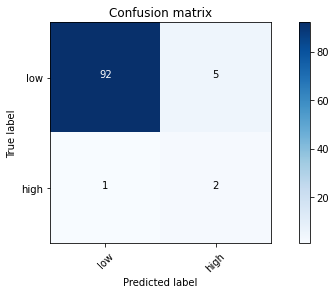

In [65]:
cm = confusion_matrix(labels_val, predicted_labels)
cm_plot_labels = ['low', 'high'] #['low', 'medium', 'high']
plot_confusion_matrix(cm, cm_plot_labels)

## Save the model to DRIVE

In [ ]:
!tar -czf BERTmodel.tar.gz model
!mv BERTmodel.tar.gz ../drive/My\ Drive/Colab\ data/BERT/ 

## Test the model

In [ ]:
#multiple inputs
#用記事本打開csv文件，另存為设置編碼為utf-8
test_data_source = "data/test_data_0817.csv"
test_data_df = pd.read_csv(test_data_source, encoding='utf8', delimiter=',')
print(test_data_df.head())

   ID                                        Description  Class
0   0  - - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - -...    NaN
1   1                     --　　　　　　　　　　　　　　　　　　　　　    　--    NaN
2   2  版友們有哪些討厭的副作用呢？今天去運動途中哭了因為副作用讓我覺得沒辦法掌控自己的身體很痛苦 ...    NaN
3   3  「我會在，你放心。我們就慢慢把環境適應。」治療的最後，L說著，想要安撫我下週工作室搬遷的焦慮...    NaN
4   4  其實我也不知道在焦慮甚麼也許是不想有人來管吧?本來是社區自聘的管理員6/1起外包給保全公司我...    NaN


In [ ]:
test_data = list(test_data_df['Description'])
print(test_data[0])

- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條　凡未分類、自創分類、未滿20字（不含標點符號）之文章，　　　　含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，　　　　初犯者板主將直接刪除文章，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條　發文內容或推文大部分內容，違反中華民國法律者，　　　　初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條　尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，　　　　除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。　　　　解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。　　　　水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條　本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，　　　　只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。　　　　此外，意見不合與人身攻擊間有很大的落差，　　　　請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，　　　　如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。　　　　　　　認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。　　　　例：「你根本不是憂鬱症吧！」、「會生病是你活該」等　　　　普通人身攻擊文劣退處理，並水桶一週；於推文中普通人身攻擊者水桶一週。　　　　其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。　　　　　　　認定標準為：該字詞足以引起一般使用者普遍性之不悅，並達到動怒的程度。　　　　例：「你去死」、「吃屎吧你」等　　　　惡意人身攻擊文劣退處理，並水桶二週；於推文中惡意人身攻擊者水桶二週。　　　　其後發文或推文仍未改善者劣退水桶二個月。三犯永久水桶。　　　　　　　認定標準為：可能觸犯刑法公然侮辱罪，含三字經、不雅形容詞等用詞。　　　　例：「幹」、「醜」、「賤」、「智障」、「白痴」、「腦殘」、「丁丁」等。　　　　公然侮辱罪需針對特定人士辱罵才能成立，用以上詞彙評論事件，　　　　或是該文章、推文中無法推斷出發表者有針對特定人物，不構成公然侮辱罪。　　　　但若有符合上述普通、惡意

In [ ]:
test_results = getPrediction(test_data)
print("#"*50)
print(test_results[0])

INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:Writing example 0 of 200


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:tokens: [CLS] - - - - - - - - - - - - - - 附 錄 ： 【 發 文 與 推 文 罰 則 】 - - - - - - - - - - - - - - 第 一 條 凡 未 分 類 、 自 創 分 類 、 未 滿 20 字 （ 不 含 標 點 符 號 ） 之 文 章 ， 含 有 自 殺 、 自 殘 、 [UNK] 相 關 內 容 ， 未 在 標 題 加 註 「 有 雷 」 或 「 雷 」 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 二 條 發 文 內 容 或 推 文 大 部 分 內 容 ， 違 反 中 華 民 國 法 律 者 ， 初 犯 者 板 主 將 直 接 刪 除 文 章 並 並 水 桶 三 日 ， 不 另 外 公 告 或 通 知 。 其 後 發 文 或 推 文 仍 未 改 善 者 劣 退 水 桶 一 個 月 。 三 犯 永 久 水 桶 。 第 三 條 尋 死 文 、 自 殺 文 、 自 殘 文 、 [UNK] 文 、 藥 物 徵 求 買 賣 文 [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_ids: 101 118 118 118 118 118 118 118 118 118 118 118 118 118 118 7353 7087 8038 523 4634 3152 5645 2972 3152 5391 1179 524 118 118 118 118 118 118 118 118 118 118 118 118 118 118 5018 671 3454 1127 3313 1146 7546 510 5632 1201 1146 7546 510 3313 4021 8113 2099 8020 679 1419 3560 7953 5016 5998 8021 722 3152 4995 8024 1419 3300 5632 3669 510 5632 3659 510 100 4685 7302 1058 2159 8024 3313 1762 3560 7539 1217 6263 519 3300 7440 520 2772 519 7440 520 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152 2772 2972 3152 793 3313 3121 1587 5442 1219 6842 3717 3446 671 943 3299 511 676 4306 3719 719 3717 3446 511 5018 753 3454 4634 3152 1058 2159 2772 2972 3152 1920 6956 1146 1058 2159 8024 6889 1353 704 5836 3696 1751 3791 2526 5442 8024 1159 4306 5442 3352 712 2200 4684 2970 1165 7370 3152 4995 699 699 3717 3446 676 3189 8024 679 1369 1912 1062 1440 2772 6858 4761 511 1071 2527 4634 3152

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:tokens: [CLS] - - - - [SEP]


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 118 118 118 118 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:tokens: [CLS] 版 友 們 有 哪 些 討 厭 的 副 作 用 呢 ？ 今 天 去 運 動 途 中 哭 了 因 為 副 作 用 讓 我 覺 得 沒 辦 法 掌 控 自 己 的 身 體 很 痛 苦 悲 從 中 來 運 動 暫 時 可 以 忘 掉 但 一 想 到 眼 淚 就 冒 出 眼 眶 好 痛 苦 但 不 能 不 吃 藥 希 望 自 己 不 要 被 藥 物 綁 住 但 現 階 段 我 不 能 不 吃 藥 . . . 好 沮 喪 感 覺 連 掌 控 權 都 沒 有 「 妳 還 好 嗎 ？ 」 人 們 問 。 「 我 不 好 。 」 她 們 就 會 一 臉 尷 尬 的 沈 默 了 不 然 你 們 希 冀 什 麼 答 案 啊 ？ - - + 1 可 以 問 但 是 不 要 對 方 回 答 負 面 的 就 不 開 心 的 沈 默 . . . [UNK] 或 是 無 語 問 蒼 天 嗯 嗯 不 要 期 待 一 個 很 正 面 的 回 答 不 要 去 預 設 一 個 美 好 的 回 應 [SEP]


INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_ids: 101 4276 1351 947 3300 1525 763 6245 1339 4638 1199 868 4500 1450 8043 791 1921 1343 6880 1240 6854 704 1526 749 1728 4158 1199 868 4500 6366 2769 6221 2533 3760 6794 3791 2958 2971 5632 2346 4638 6716 7768 2523 4578 5736 2650 2537 704 889 6880 1240 3271 3229 1377 809 2563 2957 852 671 2682 1168 4706 3907 2218 1088 1139 4706 4702 1962 4578 5736 852 679 5543 679 1391 5973 2361 3307 5632 2346 679 6206 6158 5973 4289 5192 857 852 4412 7389 3667 2769 679 5543 679 1391 5973 119 119 119 1962 3775 1603 2697 6221 6865 2958 2971 3609 6963 3760 3300 519 1986 6917 1962 1621 8043 520 782 947 1558 511 519 2769 679 1962 511 520 1961 947 2218 3298 671 5622 2220 2217 4638 3755 7949 749 679 4197 872 947 2361 1078 784 7938 5031 3428 1557 8043 118 118 116 122 1377 809 1558 852 3221 679 6206 2205 3175 1726 5031 6511 7481 4638 2218 679 7274 2552 4638 3755 7949 119 119 119 100 2772 3221 4192 6295 1558 5895 1921 1638 1638 679 6206 3309 2521 671 943 2523 3633 7481 4638 1726 5031 679

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:tokens: [CLS] 「 我 會 在 ， 你 放 心 。 我 們 就 慢 慢 把 環 境 適 應 。 」 治 療 的 最 後 ， [UNK] 說 著 ， 想 要 安 撫 我 下 週 工 作 室 搬 遷 的 焦 慮 。 當 下 覺 得 很 溫 暖 ， 很 放 心 地 微 笑 了 ， 可 是 我 現 在 卻 快 要 被 恐 懼 焦 慮 淹 沒 ， 因 為 [UNK] 也 給 過 我 太 多 承 諾 。 我 很 清 楚 [UNK] 和 [UNK] 是 截 然 不 同 的 ， [UNK] 是 會 員 是 候 選 人 ， 這 就 是 他 的 工 作 ， 所 以 他 會 在 。 這 些 我 都 知 道 ， 我 也 以 為 我 已 經 100 % 依 賴 [UNK] ， 是 可 以 懂 他 只 是 為 了 讓 我 安 心 ， 告 訴 我 他 會 在 新 的 工 作 室 等 著 我 過 去 。 可 是 我 現 在 焦 慮 到 想 吐 [UNK] 既 昨 天 腰 痛 之 後 今 天 多 了 背 痛 ， 一 定 又 是 重 訓 的 過 程 中 姿 勢 錯 誤 導 致 的 ， 但 重 點 是 我 不 知 道 問 題 在 哪 裡 > < 和 現 在 的 教 練 上 課 已 經 超 過 半 年 ， 然 而 [SEP]


INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_ids: 101 519 2769 3298 1762 8024 872 3123 2552 511 2769 947 2218 2714 2714 2828 4472 1862 6900 2746 511 520 3780 4615 4638 3297 2527 8024 100 6303 5865 8024 2682 6206 2128 3062 2769 678 6867 2339 868 2147 3021 6907 4638 4193 2719 511 4534 678 6221 2533 2523 3984 3265 8024 2523 3123 2552 1765 2544 5010 749 8024 1377 3221 2769 4412 1762 1320 2571 6206 6158 2607 2758 4193 2719 3922 3760 8024 1728 4158 100 738 5183 6882 2769 1922 1914 2824 6330 511 2769 2523 3926 3504 100 1469 100 3221 2779 4197 679 1398 4638 8024 100 3221 3298 1519 3221 952 6908 782 8024 6857 2218 3221 800 4638 2339 868 8024 2792 809 800 3298 1762 511 6857 763 2769 6963 4761 6887 8024 2769 738 809 4158 2769 2347 5195 8135 110 898 6552 100 8024 3221 1377 809 2743 800 1372 3221 4158 749 6366 2769 2128 2552 8024 1440 6260 2769 800 3298 1762 3173 4638 2339 868 2147 5023 5865 2769 6882 1343 511 1377 3221 2769 4412 1762 4193 2719 1168 2682 1402 100 3188 3219 1921 5587 4578 722 2527 791 1921 1914 749 5520 4

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 也 不 知 道 在 焦 慮 甚 麼 也 許 是 不 想 有 人 來 管 吧 ? 本 來 是 社 區 自 聘 的 管 理 員 6 / 1 起 外 包 給 保 全 公 司 我 也 確 定 留 任 了 可 是 從 得 知 消 息 之 後 還 是 一 樣 焦 慮 今 天 去 保 全 公 司 面 談 ， 填 了 一 堆 不 知 道 是 甚 麼 的 資 料 （ 這 點 很 危 險 ， 好 孩 子 不 要 學 ） 因 為 還 有 另 一 個 同 事 不 知 為 何 早 到 ， 保 全 公 司 的 說 要 一 起 解 釋 ， 所 以 我 不 好 意 思 讓 他 等 其 實 事 後 也 沒 有 甚 麼 解 釋 ， 很 多 事 沒 搞 清 楚 其 實 就 制 度 面 來 說 ， 有 公 司 會 比 較 好 至 少 以 後 勞 健 保 有 著 落 了 以 後 上 班 時 間 相 對 固 定 ， 輪 班 不 像 現 在 這 樣 常 常 日 夜 顛 倒 而 且 工 作 地 點 沒 變 ， 服 務 對 象 沒 變 但 一 想 到 上 面 突 然 多 了 陌 生 人 來 管 就 覺 得 莫 名 害 怕 上 次 這 樣 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_ids: 101 1071 2179 2769 738 679 4761 6887 1762 4193 2719 4493 7938 738 6258 3221 679 2682 3300 782 889 5052 1416 136 3315 889 3221 4852 1281 5632 5470 4638 5052 4415 1519 127 120 122 6629 1912 1259 5183 924 1059 1062 1385 2769 738 4825 2137 4522 818 749 1377 3221 2537 2533 4761 3867 2622 722 2527 6917 3221 671 3564 4193 2719 791 1921 1343 924 1059 1062 1385 7481 6312 8024 1856 749 671 1831 679 4761 6887 3221 4493 7938 4638 6536 3160 8020 6857 7953 2523 1314 7402 8024 1962 2111 2094 679 6206 2119 8021 1728 4158 6917 3300 1369 671 943 1398 752 679 4761 4158 862 3193 1168 8024 924 1059 1062 1385 4638 6303 6206 671 6629 6237 7026 8024 2792 809 2769 679 1962 2692 2590 6366 800 5023 1071 2179 752 2527 738 3760 3300 4493 7938 6237 7026 8024 2523 1914 752 3760 3018 3926 3504 1071 2179 2218 1169 2428 7481 889 6303 8024 3300 1062 1385 3298 3683 6733 1962 5635 2208 809 2527 1246 978 924 3300 5865 5862 749 809 2527 677 4408 3229 7279 4685 2205 1743 2137 8024 6743 4408 679 100

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


##################################################
('- - - - - - - - - - - - - -附錄：【發文與推文罰則】- - - - - - - - - - - - - -第一條\u3000凡未分類、自創分類、未滿20字（不含標點符號）之文章，\u3000\u3000\u3000\u3000含有自殺、自殘、OD相關內容，未在標題加註「有雷」或「雷」者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第二條\u3000發文內容或推文大部分內容，違反中華民國法律者，\u3000\u3000\u3000\u3000初犯者板主將直接刪除文章並並水桶三日，不另外公告或通知。\u3000\u3000\u3000\u3000其後發文或推文仍未改善者劣退水桶一個月。三犯永久水桶。第三條\u3000尋死文、自殺文、自殘文、OD文、藥物徵求買賣文等違規文章，\u3000\u3000\u3000\u3000除自殺文暫保留二日以便板友關心追蹤外，其餘文直接刪除並水桶三日。\u3000\u3000\u3000\u3000解除水桶之後其發文仍未遵循板規者，其發文劣退並水桶一個月。\u3000\u3000\u3000\u3000水桶後無論自行發文或在其他板友文章內推文再犯者皆永久水桶。第四條\u3000本板對人身攻擊定義，不論是主動攻擊他人或因對他人言論不滿而回擊者，\u3000\u3000\u3000\u3000只要構成人身攻擊之事實，即視為違規，依程度輕重照板規懲處。\u3000\u3000\u3000\u3000此外，意見不合與人身攻擊間有很大的落差，\u3000\u3000\u3000\u3000請發文推文者勿因他人持反對意見，就任意指責對方人身攻擊，\u3000\u3000\u3000\u3000如經板主認定檢舉人有濫訴之嫌，得以不回應其檢舉。\u3000\u3000\u3000\u3000\u3000\u3000\u3000認定標準為：該字詞足以引起本板板友普遍性之不悅，並達到動怒的程度。\u3000\u3000\u3000\u3000例：「你根本不是憂鬱症吧！」、「會生病是

In [ ]:
results = [tr[2] for tr in test_results]
print(results)

[0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]


In [ ]:
test_data_df['Predicted'] = results
test_data_df.to_csv('data/suicide_test_result.csv', encoding='utf8')

## Free test here

In [ ]:
#Classifying random sentences
test_results = getPrediction(['其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
                       '帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
                       '還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
                       '群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 '
                       ])

INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:Writing example 0 of 4


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:tokens: [CLS] 其 實 我 本 來 就 不 太 想 活 了 每 次 和 媽 媽 說 完 話 我 就 開 始 辜 狗 自 殺 方 法 [SEP]


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1071 2179 2769 3315 889 2218 679 1922 2682 3833 749 3680 3613 1469 2061 2061 6303 2130 6282 2769 2218 7274 1993 6790 4318 5632 3669 3175 3791 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:tokens: [CLS] 帶 了 很 多 藥 來 就 是 因 為 怕 這 樣 的 時 刻 又 出 現 這 才 是 真 正 的 逢 魔 時 刻 吧 想 自 我 毀 滅 盡 量 躺 著 保 持 安 靜 再 撐 幾 天 就 回 家 了 沒 事 的 [SEP]


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2380 749 2523 1914 5973 889 2218 3221 1728 4158 2586 6857 3564 4638 3229 1174 1348 1139 4412 6857 2798 3221 4696 3633 4638 6864 7795 3229 1174 1416 2682 5632 2769 3672 3994 4674 7030 6720 5865 924 2898 2128 7477 1086 3052 2407 1921 2218 1726 2157 749 3760 752 4638 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:tokens: [CLS] 還 有 半 小 時 覺 得 倦 怠 低 落 負 面 而 自 我 放 逐 下 班 要 吃 冰 冰 彷 彿 是 每 天 的 救 贖 潰 瘍 還 沒 好 [SEP]


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6917 3300 1288 2207 3229 6221 2533 958 2591 856 5862 6511 7481 5445 5632 2769 3123 6852 678 4408 6206 1391 1102 1102 2513 2517 3221 3680 1921 4638 3131 6562 4061 4598 6917 3760 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:tokens: [CLS] 群 組 裡 面 都 是 很 負 面 的 話 受 不 了 就 不 要 加 入 下 輩 子 再 見 也 可 以 說 不 定 會 好 [SEP]


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 5408 5175 6174 7481 6963 3221 2523 6511 7481 4638 6282 1358 679 749 2218 679 6206 1217 1057 678 6742 2094 1086 6210 738 1377 809 6303 679 2137 3298 1962 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Restoring parameters from model/model.ckpt-70


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [ ]:
test_results

[('其實我本來就不太想活了每次和媽媽說完話我就開始辜狗自殺方法',
  array([-4.2940416 , -0.01525544, -6.508965  ], dtype=float32),
  1,
  'medium'),
 ('帶了很多藥來就是因為怕這樣的時刻又出現這才是真正的逢魔時刻吧想自我毀滅盡量躺著保持安靜再撐幾天就回家了沒事的',
  array([-4.380038  , -0.01521951, -5.9602184 ], dtype=float32),
  1,
  'medium'),
 ('還有半小時覺得倦怠低落負面而自我放逐下班要吃冰冰彷彿是每天的救贖潰瘍還沒好',
  array([-3.3580725 , -0.03784102, -6.06114   ], dtype=float32),
  1,
  'medium'),
 ('群組裡面都是很負面的話受不了就不要加入下輩子再見也可以說不定會好 ',
  array([-1.7969489 , -0.18484534, -5.821481  ], dtype=float32),
  1,
  'medium')]

Reference: https://analyticsindiamag.com/step-by-step-guide-to-implement-multi-class-classification-with-bert-tensorflow/